In [56]:
import pandas as pd
import numpy as np
import time
from seaborn import heatmap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from utils import evaluate_model, create_sampling_datasets, create_train_test_sampled_split,train_and_evaluate
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt # Sollte 3.7.3 sein -> 3.8.0 macht Probleme bei der Darstellung der Konfusionsmatrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
pd.options.mode.copy_on_write = True

In [2]:
# Einlesen der Datensätze
df_preprocessed = pd.read_csv("../../data/preprocessed/PSP_Jan_Feb_2019_preprocessed.csv", sep=";")
df_preprocessed_feature_selection = pd.read_csv("../../data/preprocessed/PSP_Jan_Feb_2019_preprocessed_general_feature_selection.csv", sep=";")

In [3]:
# Festlegen von Samplern RUS und ROS
samplers = samplers = {"RUS": RandomUnderSampler(random_state=42), "ROS": RandomOverSampler(random_state=42)}
# Erstellen eines Dictionary, welches Trainings und Testdatensätze für die zuvor eingelesenen Daten enthält.
# Dies geschieht vor dem Sampling, da sonst bei ROS ein Informationsfluss der Trainings- in die Testdaten geschehen kann.
prep_data = create_train_test_sampled_split(df_preprocessed, df_preprocessed_feature_selection)

In [4]:
# Definition von vier Baseline ML-Algorithmen in einem Dictionary, um das iterative Training dieser zu ermöglichen.
# Festlegen von random_state, um die Reproduzierbarkeit zu gewährleisten
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [6]:
feature_set_list, sampling_list, classifier_list, result_list = [],[],[],[]

for feature_set in prep_data.keys():
    # Training und Evaluierung ohne Sampling
    for classifier in classifiers.keys():
        # Jeder Klasifizierer wird trainiert und evaluiert. Die Ergebnisse der Evaluation werden in einer Liste gespeichert.
        feature_set_list.append(feature_set)
        sampling_list.append(None)
        classifier_list.append(classifier)
        result_list.append(train_and_evaluate(classifiers[classifier],
                                                         prep_data[feature_set]["X_train"],
                                                         prep_data[feature_set]["y_train"],
                                                         prep_data[feature_set]["X_test"],
                                                         prep_data[feature_set]["y_test"]))
    # Erstellen von RUS und ROS Sampling Datensätzen    
    dataset = create_sampling_datasets(samplers,prep_data[feature_set]["X_train"],prep_data[feature_set]["y_train"])
    
    # Für RUS und ROS:
    for sampling_tech in dataset.keys():
        # Training und Evaluierung mit Sampling
        for classifier in classifiers.keys():
            # Each classifier is trained and results written to list
            feature_set_list.append(feature_set)
            sampling_list.append(sampling_tech)
            classifier_list.append(classifier)
            result_list.append(train_and_evaluate(classifiers[classifier],
                                                         dataset[sampling_tech][0],
                                                         dataset[sampling_tech][1],
                                                         prep_data[feature_set]["X_test"],
                                                         prep_data[feature_set]["y_test"]))

In [7]:
# Erstellen eines metrics dictionary, welches die Informationen über Sampling, Klassifizierer und Featureset enthält.
metrics = {"classifier":classifier_list,
          "sampling_mode":sampling_list,
          "feature_set":feature_set_list}
# Hinzufügen der Trainingsevaluierungen
for vals, metric in zip([[row[key] for row in result_list] for key in result_list[0].keys()], result_list[0].keys()):
    metrics[metric] = vals
# Erstellen eines DataFrame aus dem Dictionary
pd.DataFrame(metrics).sort_values("auc_score", ascending=False)

,classifier,sampling_mode,feature_set,accuracy,f1_score,precision,recall,auc_score
2,Gradient Boosting,None,All Features,0.799026,0.012689,0.722222,0.006401,0.665638
8,Gradient Boosting,ROS,All Features,0.596662,0.404343,0.287983,0.678484,0.663823
5,Gradient Boosting,RUS,All Features,0.593682,0.400645,0.285208,0.673067,0.656660
11,Gradient Boosting,None,Selected Features,0.798232,0.008785,0.500000,0.004431,0.655511
17,Gradient Boosting,ROS,Selected Features,0.608484,0.399146,0.289090,0.644510,0.652782
14,Gradient Boosting,RUS,Selected Features,0.604610,0.396421,0.286434,0.643525,0.649740
4,Random Forest,RUS,All Features,0.601133,0.370788,0.271954,0.582472,0.622528
1,Random Forest,None,All Features,0.773694,0.164956,0.322812,0.110783,0.613825
7,Random Forest,ROS,All Features,0.739221,0.244169,0.294036,0.208764,0.607309
13,Random Forest,RUS,Selected Features,0.567057,0.336278,0.243440,0.543575,0.590649


In [8]:
# Bestimmen der besten Kombination aus Featureset und Sampling für jeden Klassifizierer
df = pd.DataFrame(metrics)
# Kombination soll nur Sampling Datensätze berücksichtigen.
df = df[~df["sampling_mode"].isnull()]
# Bestimmen der besten Kombination:
selected_combinations = df[df.groupby("classifier")["auc_score"].transform("max") == df["auc_score"]].reset_index(drop=True)
selected_combinations.head()

,classifier,sampling_mode,feature_set,accuracy,f1_score,precision,recall,auc_score
0,Random Forest,RUS,All Features,0.601133,0.370788,0.271954,0.582472,0.622528
1,Gradient Boosting,ROS,All Features,0.596662,0.404343,0.287983,0.678484,0.663823
2,Decision Tree,RUS,Selected Features,0.591397,0.327612,0.245228,0.493353,0.555221


### Erkenntnisse:
 - GB, LR underfitten extrem auf dem unausgeglichenen Datensatz
 - DT und RF sind weniger stark davon betroffen
 - GB bestes Modell ootb
 - RUS und ROS unterscheiden sich bei GB kaum
 - RUS ROS nur wenig Auswirkungen auf AUC Score
 - Wichtig Recall und Prec anzuschauen
 - Alle Features sind bei GB und LR kontraproduktiv bei DT und RF sind alle features besser.

## Hyperparameter Tuning

In [7]:
class Timer():
    """
    Basis Timer Klasse, welche durch ein "with" Statement aufgerufen wird und nach verlassen dessen die verbrauchte Rechenzeit ausgibt.
    """
    def __init__(self):
        return
    def __enter__(self):
        self.start = time.time()
        return
    def __exit__(self, exc_type, exc_value, tb):
        self.end = time.time()
        print(self.end - self.start)
        return

In [5]:
# Datensätze mit ausgewählten Features und allen Features trennen:
dataset_selected = create_sampling_datasets(samplers,
                                   prep_data["Selected Features"]["X_train"],
                                   prep_data["Selected Features"]["y_train"])
dataset_all = create_sampling_datasets(samplers,
                                   prep_data["All Features"]["X_train"],
                                   prep_data["All Features"]["y_train"])

In [11]:
# Gridsearch mit Kreuzvalidierung für die beste Gradient Boosting Kombination 
parameters = {'n_estimators':(100, 120),
              'max_depth':(3,4), 
              'min_samples_split':(2,4),
              'min_samples_leaf':(1,2,4)
             }
clf = classifiers["Gradient Boosting"]
clf_GB = GridSearchCV(clf, 
                      parameters, 
                      refit = "roc_auc", 
                      scoring=["f1","precision","recall","accuracy","roc_auc"], 
                      cv = 5) # CHANGE
with Timer():
    clf_GB.fit(dataset_all["ROS"][0], dataset_all["ROS"][1])

902.8433380126953


In [12]:
clf_GB.best_params_

{'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 120}

In [13]:
# Gridsearch mit Kreuzvalidierung für die beste Random Forest Kombination 
parameters = {'n_estimators':(50, 100, 200), 
              'criterion':('gini','entropy'), 
              'max_depth':(5,8,11), 
              'min_samples_split':(2,4,8)
             }
clf = classifiers["Random Forest"]
clf_RF = GridSearchCV(clf, 
                      parameters, 
                      refit = "roc_auc", 
                      scoring=["f1","precision","recall","accuracy","roc_auc"], 
                      cv = 5)
with Timer():
    clf_RF.fit(dataset_all["RUS"][0], dataset_all["RUS"][1])

224.7107195854187


In [14]:
clf_RF.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_split': 8,
 'n_estimators': 200}

In [15]:
# Evaluierung der beiden trainierten Klassifizierer mit den Testdaten und Ausgabe der besten Hyperparameter.
for clf, feature in zip([clf_GB, clf_RF],["Gradient Boosting","Random Forest"]):
    feature_sel = selected_combinations[selected_combinations["classifier"]==feature].iloc[0]['feature_set']
    print(feature_sel, feature)
    print(clf.best_params_)
    y_pred = clf.predict(prep_data[feature_sel]["X_test"])
    y_prob = clf.predict_proba(prep_data[feature_sel]["X_test"])[:, 1]
    print(evaluate_model(prep_data[feature_sel]["y_test"], y_pred, y_prob))

All Features Gradient Boosting
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 120}
accuracy :   0.6132525332803497
f1_score :   0.40808879428310774
precision :   0.29520457545094586
recall :   0.6607582471688823
auc_score :   0.6706974073607681
confusion_matrix :   [[4831 3204]
 [ 689 1342]]
{'accuracy': 0.6132525332803497, 'f1_score': 0.40808879428310774, 'precision': 0.29520457545094586, 'recall': 0.6607582471688823, 'auc_score': 0.6706974073607681, 'confusion_matrix': array([[4831, 3204],
       [ 689, 1342]], dtype=int64)}
All Features Random Forest
{'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 8, 'n_estimators': 200}
accuracy :   0.5924895688456189
f1_score :   0.40481717933836336
precision :   0.2869779880682987
recall :   0.6868537666174298
auc_score :   0.6589413560870601
confusion_matrix :   [[4569 3466]
 [ 636 1395]]
{'accuracy': 0.5924895688456189, 'f1_score': 0.40481717933836336, 'precision': 0.2869779880682987, 'recall': 0.686

# Feature Importance

In [8]:
# Definieren und trainieren von neuen GB und RF Klassifikatoren mit den optimierten Hyperparametern
clf_GB_tuned = GradientBoostingClassifier(max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120)
clf_RF_tuned = RandomForestClassifier(criterion="gini",max_depth=11, min_samples_split=8, n_estimators=200)
with Timer():
    clf_GB_tuned.fit(dataset_all["ROS"][0], dataset_all["ROS"][1])
    clf_RF_tuned.fit(dataset_all["RUS"][0], dataset_all["RUS"][1])

9.422101020812988


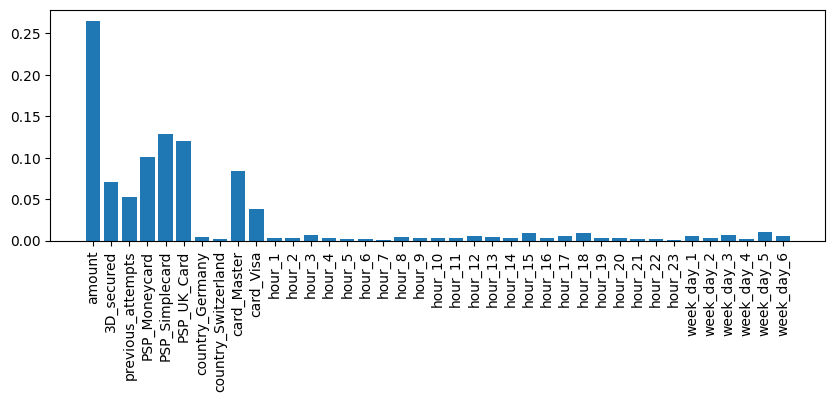

In [9]:
# Plot erstellen, der die Wichtigkeit der Features für das GB Modell darstellt.
plt.figure(figsize=(10,3))
plt.bar(range(len(clf_GB_tuned.feature_importances_)), clf_GB_tuned.feature_importances_)
plt.xticks(range(len(clf_GB_tuned.feature_importances_)), dataset_all["RUS"][0].columns, rotation='vertical')
plt.savefig("../../documentation/model-reports/feature_importance_gb.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [18]:
pd.DataFrame([clf_RF_tuned.feature_importances_],columns=dataset_all["RUS"][0].columns)

,amount,3D_secured,previous_attempts,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,country_Germany,country_Switzerland,card_Master,card_Visa,...,hour_20,hour_21,hour_22,hour_23,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
0,0.28069,0.053537,0.073615,0.037212,0.08862,0.073737,0.021061,0.018814,0.045324,0.030194,...,0.007584,0.00751,0.006881,0.006938,0.016361,0.0148,0.016263,0.014846,0.016685,0.015703


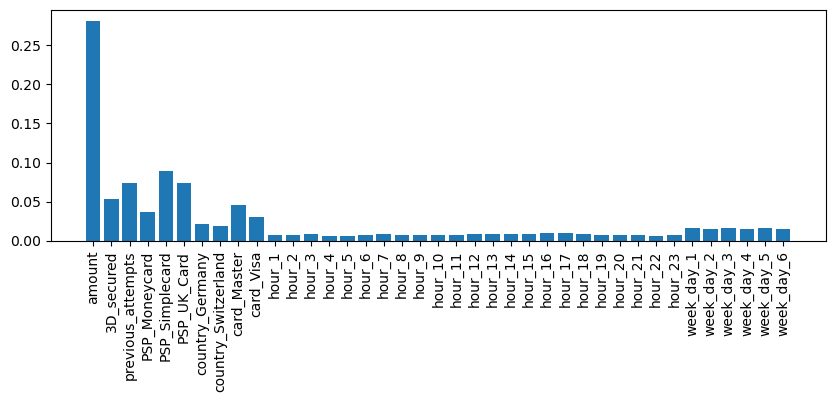

In [19]:
# Plot erstellen, der die Wichtigkeit der Features für das RF Modell darstellt.
plt.figure(figsize=(10,3))
plt.bar(range(len(clf_RF_tuned.feature_importances_)), clf_RF_tuned.feature_importances_)
plt.xticks(range(len(clf_RF_tuned.feature_importances_)), dataset_all["RUS"][0].columns, rotation='vertical')
plt.savefig("../../documentation/model-reports/feature_importance_rf.pdf", format="pdf", bbox_inches="tight")
plt.show()

accuracy :   0.6132525332803497
f1_score :   0.40808879428310774
precision :   0.29520457545094586
recall :   0.6607582471688823
auc_score :   0.6706098411767571
confusion_matrix :   [[4831 3204]
 [ 689 1342]]
accuracy :   0.5911980925889132
f1_score :   0.4031907179115301
precision :   0.2857730263157895
recall :   0.6843919251600197
auc_score :   0.6593256607217868
confusion_matrix :   [[4561 3474]
 [ 641 1390]]


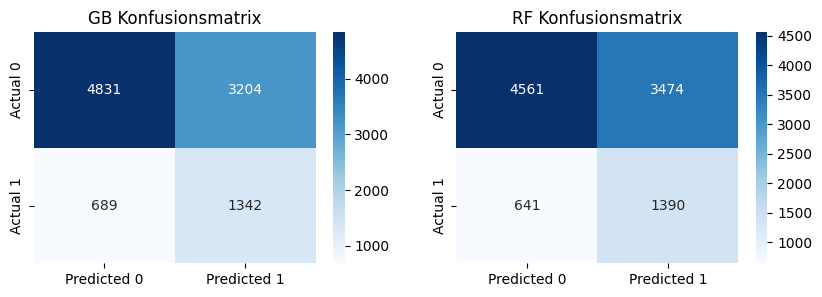

In [10]:
# Erstellen von Konfusionsmatizen für beide Klassifizierer
feature_set = "All Features"
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 3))
for tuned_clf, clf_name, ax in zip([clf_GB_tuned,clf_RF_tuned],["GB","RF"],[ax1, ax2]):
    # Vorhersage auf Testdaten
    y_pred = tuned_clf.predict(prep_data[feature_set]["X_test"])
    # Vorhersage der Wahrscheinlichkeiten von beiden Klassen
    y_probs = tuned_clf.predict_proba(prep_data[feature_set]["X_test"])[:, 1]
    # Modellevaluierung
    res = evaluate_model(prep_data[feature_set]["y_test"], y_pred, y_probs)
    # Nutzung von Seaborns Heatmap
    heatmap(res["confusion_matrix"], annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f"{clf_name} Konfusionsmatrix")
plt.savefig(f"../../documentation/model-reports/confusion_matrix_GB_RF.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Wann hat das Modell Schwächen?

In [11]:
def define_PSP(row):
    """
    Diese Funktion nimmt ein Zeilenelement eines DataFrame und bestimmt basierend auf den One Hot Kodierten Spalten den PSP
    """
    if row["PSP_Moneycard"]:
        return "Moneycard"
    if row["PSP_Simplecard"]:
        return "Simplecard"
    if row["PSP_UK_Card"]:
        return "UK_Card"
    else:
        return "Goldcard"

def define_card(row):
    """
    Diese Funktion nimmt ein Zeilenelement eines DataFrame und bestimmt basierend auf den One Hot Kodierten Spalten die Kartenart
    """
    if row["card_Master"]:
        return "Master"
    if row["card_Visa"]:
        return "Visa"
    else:
        return "Diners"

In [31]:
prep_with_predictions = prep_data["All Features"]["X_test"].copy()
# Vorhersage auf Testdaten
y_pred = clf_GB_tuned.predict(prep_with_predictions)
y_true = prep_data[feature_set]["y_test"].copy()
# Vorhersage ungleich Wahrheit
error = y_pred != y_true
# Falsch Positiv: Modell sagt Erfolg vorher, aber Wahrheit ist Fehlschlag
fp = (y_pred==1) & (y_true==0)
fn = (y_pred==0) & (y_true==1)
prep_with_predictions["PSP"] = prep_with_predictions.apply(define_PSP, axis=1)
prep_with_predictions["card"] = prep_with_predictions.apply(define_card, axis=1)

C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

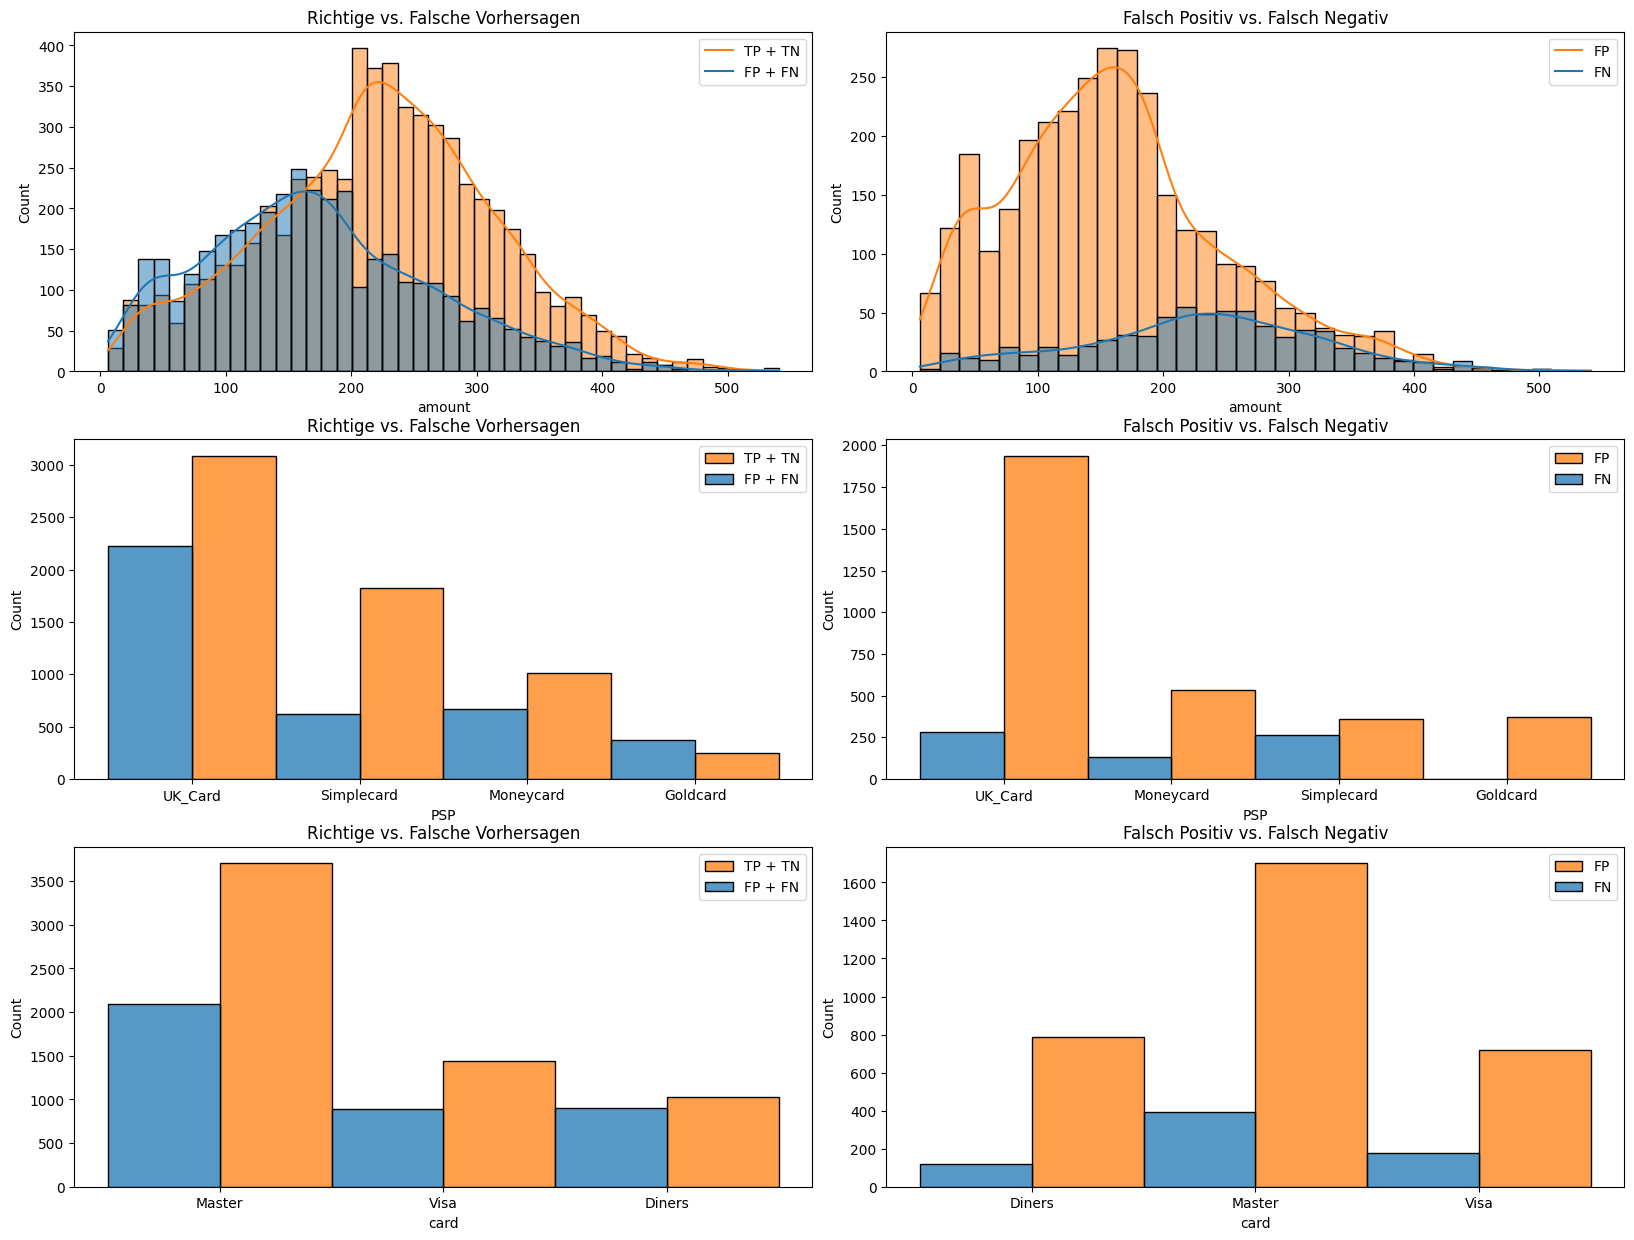

In [32]:
pd.set_option("mode.copy_on_write", False)

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
plt.subplots_adjust(wspace=0.1)
# Plots für die wichtigsten Features erstellen, um die Herkunft des Fehlers zu analysieren.
for feature, ax in zip(["amount","PSP","card"], axes):
    # Histogramm erstellen, welches die korrekten gegen die falschen Klassifizierungen darstellt.
    sns.histplot(data=prep_with_predictions, x=feature, hue=~error, multiple="layer" if feature == "amount" else "dodge" , kde = True if feature == "amount" else False, ax = ax[0]);
    ax[0].legend(labels=["TP + TN", "FP + FN"]);
    ax[0].set_title("Richtige vs. Falsche Vorhersagen");
    # Histogramm erstellen, welches den Unterschied bzgl. FP und FN zeigt.
    sns.histplot(data=prep_with_predictions[error], x=feature, hue=fp, multiple="layer" if feature == "amount" else "dodge", kde = True if feature == "amount" else False, ax = ax[1]);
    ax[1].legend(labels=["FP", "FN"]);
    ax[1].set_title("Falsch Positiv vs. Falsch Negativ");
# plt.savefig("../../documentation/model-reports/fault_analysis.pdf", format="pdf", bbox_inches="tight")

In [33]:
len(prep_with_predictions[fn][prep_with_predictions[fn]["PSP"]=="Goldcard"])

3

In [34]:
diners_error = len(prep_with_predictions[error][prep_with_predictions[error]["card"]=="Diners"])
diners_success =len(prep_with_predictions[~error][prep_with_predictions[~error]["card"]=="Diners"])
print("Diners Card Error Rate:", diners_error/(diners_error+diners_success))

Diners Card Error Rate: 0.4694300518134715


# Nutzung im Unternehmenskontext


In [53]:
permutations = {"Goldcard":[0, 0, 0],
                "Moneycard":[1, 0, 0],
                "Simplecard":[0, 1, 0],
                "UK_Card":[0, 0, 1]}

transaction = prep_data[feature_set]["X_test"].copy()
all_data = transaction.copy()
all_data["success"] = prep_data[feature_set]["y_test"]
all_data.reset_index(inplace=True)
all_data["psp"] = all_data.apply(define_PSP, axis=1)
data_list=[]
with Timer():
    # Iteriere durch den gesamten Datensatz
    for row in all_data.to_dict(orient="records"):
        for PSP in permutations.keys():
            if row["psp"] != PSP:
                # Erstellen von Zeilen für alle anderen PSP. Die restlichen Features bleiben gleich.
                row["PSP_Moneycard"] = permutations[PSP][0]
                row["PSP_Simplecard"] = permutations[PSP][1]
                row["PSP_UK_Card"] = permutations[PSP][2]
                data_list.append(row.copy())
    all_data_all_psp = pd.concat([all_data, pd.DataFrame(data_list)],ignore_index=True)

useful_cols = all_data_all_psp[["index","psp","success"]]
all_data_all_psp.drop(["index","psp","success"],axis=1, inplace=True)
all_data_all_psp["proba"] = clf_GB_tuned.predict_proba(all_data_all_psp)[:,1]

all_probs_all_psp = all_data_all_psp.join(useful_cols)

# Gruppieren aller Transaktionen, um den PSP mit der maximalen Wahrscheinlichkeit zu erhalten
max_probs = pd.DataFrame(all_probs_all_psp.groupby("index")["proba"].max()).reset_index()
# Hinzufügen der One Hot PSP Spalten 
df_max_probs = pd.merge(max_probs, all_probs_all_psp, left_on=["index","proba"],right_on = ["index","proba"])
# Dekodieren der One Hot PSP Spalten
df_max_probs["predicted_psp"] = df_max_probs.apply(define_PSP, axis=1)
# Ausgabe der ausgewählten PSP
df_max_probs["predicted_psp"].value_counts()

0.3189058303833008


predicted_psp
Goldcard     9950
Moneycard     112
UK_Card         4
Name: count, dtype: int64

# Erkenntnisse:
 - In den meisten Fällen hat der PSP Goldcard die höchste Erfolgswahrscheinlichkeit. Dieser ist mit Abstand der teuerste PSP
 - Daher ist eine Auswahl des PSP mit der höchsten Erfolgswahrscheinlichkeit nicht sinnvoll.
 - Stattdessen: Wenn Wahrscheinlichkeit >50% dann wähle den günstigsten PSP aus. Wenn keiner >50%: Dann wähle den günstigsten aus oder verhindere ggf. die Zahlung

# Beispiel Auswahl eines PSP:

In [40]:
psp_dict = {
    "Moneycard": {"amount_success":5, "amount_failed":2},
    "Goldcard": {"amount_success":10, "amount_failed":5},
    "UK_Card": {"amount_success":3, "amount_failed":1},
    "Simplecard": {"amount_success":1, "amount_failed":0.5},
}

In [38]:
def select_cheapest_psp(candidates, psp_dict, success):
    cost = 20.0
    if success:
        for candidate in candidates:
            if psp_dict[candidate]["amount_success"] < cost:
                cost = psp_dict[candidate]["amount_success"]
                psp_selected = candidate
    else: 
        for candidate in candidates:
            if psp_dict[candidate]["amount_failed"] < cost:
                cost = psp_dict[candidate]["amount_failed"]
                psp_selected = candidate            
    return psp_selected
            

In [55]:
# Erstellen eines möglichen Szenarios zur Vorhersage:
feature_set = "All Features"
# Zufällige Auswahl eines Datensatzes aus den Testdaten
transaction = prep_data[feature_set]["X_test"].sample(1)
index = transaction.index[0]
# Bestimmen des PSP aus One Hot Spalten
real_psp = transaction.apply(define_PSP, axis=1).iloc[0]
transaction.reset_index(drop=True, inplace=True)

success_rates = []
for PSP in permutations.keys():
    # Iterative Vorhersage der Wahrscheinlichkeiten für Erfolg je PSP
    transaction.loc[0, "PSP_Moneycard"] = permutations[PSP][0]
    transaction.loc[0, "PSP_Simplecard"] = permutations[PSP][1]
    transaction.loc[0, "PSP_UK_Card"] = permutations[PSP][2]
    success_rates.append(clf_RF_tuned.predict_proba(transaction)[0][1])
# Erstellen eines DataFrame, der das Reale Ergebnis und die Wahl/Wahrscheinlichkeit für Erfolg des Modells gegenüberstellt
df = pd.DataFrame()
df["prob"]=success_rates
df["PSP"]=permutations.keys()
df["real_result"] = prep_data[feature_set]["y_test"].loc[index]
df["real_psp"] = real_psp
# Auswahl aller PSP, die bessere Aussicht auf Erfolg als auf Fehlschlag haben.
candidates = df[df["prob"]>0.5]
if len(candidates) > 0:
    # Es gibt einen oder mehrere PSP mit ausreichender Erfolgswahrscheinlichkeit.
    print("Selected:", select_cheapest_psp(candidates.PSP.to_list(), psp_dict, True))
else:
    # Keiner der PSP hat eine Erfolgswahrscheinlichkeit <50% -> Günstigsten für Fehlschlag auswählen.
    print("Selected:", select_cheapest_psp(df.PSP.to_list(), psp_dict, False))
df

Selected: UK_Card


,prob,PSP,real_result,real_psp
0,0.577105,Goldcard,0,UK_Card
1,0.498593,Moneycard,0,UK_Card
2,0.352722,Simplecard,0,UK_Card
3,0.528401,UK_Card,0,UK_Card


## Erkenntnisse:
 - Die Auswahl des günstigsten PSP, der Erfolg verspricht führt zu einer variableren Auswahl des PSP.
 - Im finanziellen Kontext erscheint dieser Ansatz sinnvoller, als immer den teuersten PSP zu verwenden, auch wenn dies erst in einer produktiven Umgebung verifiziert werden kann.